# Analysis of Rust Derive Statements

## Research Questions Analysis

This notebook addresses five key research questions about derive ordering patterns in Rust codebases:

1. **Prevalence of ordering conventions**: Common orderings across codebases
2. **Consistency within projects**: Ordering consistency within individual repositories  
3. **Variation across communities**: Differences between domains/project types
4. **Patterns versus noise**: Statistical significance of observed patterns
5. **Implications for formatting tools**: Recommendations for rustfmt

In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from itertools import combinations, permutations
from scipy import stats
import os
import re
from pathlib import Path

outdir = Path("./plots")
os.makedirs(outdir, exist_ok=True)

plt.rcParams.update({
    "font.family": "sans-serif", 
    "font.sans-serif": ["Fira Code Medium"],
})

sns.set_theme(style="darkgrid", context="notebook")
CSV_PATH = "./out/derive_analysis.csv"

In [2]:
# Load and preprocess data
df = pl.read_csv(CSV_PATH)

# Clean repository names (keep only the repo name, not full path)
df = df.with_columns(
    pl.col("repository").str.replace(r".*/", "").alias("repository")
)

print(f"Total derive statements: {len(df):,}")
print(f"Unique repositories: {df['repository'].n_unique()}")
print(f"Repository names: {sorted(df['repository'].unique().to_list())}")

display(df.head())

Total derive statements: 41,646
Unique repositories: 42
Repository names: ['ChatGPT', 'Graphite', 'Pake', 'alacritty', 'awesome-rust', 'bat', 'bevy', 'codex', 'czkawka', 'delta', 'deno', 'difftastic', 'exa', 'fd', 'fish-shell', 'fuel-core', 'fuels-rs', 'helix', 'influxdb', 'lapce', 'mdBook', 'meilisearch', 'polars', 'ripgrep', 'ruff', 'rust', 'rust-course', 'rustdesk', 'rustlings', 'starship', 'sway', 'swc', 'tauri', 'tokio', 'tree-sitter', 'typst', 'union', 'uv', 'vaultwarden', 'yew', 'zed', 'zellij']


repository,file_path,line_number,derives,full_line,derive_count,file_extension,directory_depth
str,str,i64,str,str,i64,str,i64
"""tauri""","""bench/src/utils.rs""",16,"""Default, Clone, Serialize, Des…","""#[derive(Default, Clone, Seria…",5,""".rs""",2
"""tauri""","""bench/src/utils.rs""",16,"""Debug, Clone, Serialize""","""#[derive(Default, Clone, Seria…",3,""".rs""",2
"""tauri""","""crates/tauri-build/src/acl.rs""",31,"""Debug, Default, Clone""","""#[derive(Debug, Default, Clone…",3,""".rs""",3
"""tauri""","""crates/tauri-build/src/acl.rs""",31,"""Debug, Clone""","""#[derive(Debug, Default, Clone…",2,""".rs""",3
"""tauri""","""crates/tauri-build/src/acl.rs""",31,"""Debug, Default, Clone, Copy""","""#[derive(Debug, Default, Clone…",4,""".rs""",3


In [3]:
## Data Preprocessing Functions

def parse_derives(derive_string):
    """Parse a derive string into a list of individual derive traits."""
    if pd.isna(derive_string) or derive_string == "":
        return []
    
    # Remove whitespace and split by comma
    derives = [d.strip() for d in derive_string.split(',')]
    # Filter out empty strings
    derives = [d for d in derives if d]
    return derives

def get_derive_pairs(derive_list):
    """Get all ordered pairs from a list of derives."""
    if len(derive_list) < 2:
        return []
    return list(combinations(derive_list, 2))

def get_derive_sequences(derive_list):
    """Get all adjacent sequences of length 2+ from derive list."""
    sequences = []
    for i in range(len(derive_list) - 1):
        sequences.append((derive_list[i], derive_list[i + 1]))
    return sequences

def calculate_consistency_score(derive_patterns):
    """Calculate consistency score for a list of derive patterns.
    
    Args:
        derive_patterns: List of derive lists for a repository
        
    Returns:
        float: Consistency score between 0 (completely inconsistent) and 1 (perfectly consistent)
    """
    if len(derive_patterns) <= 1:
        return 1.0
    
    # Count occurrences of each derive pair ordering
    pair_counts = defaultdict(int)
    total_pairs = 0
    
    for pattern in derive_patterns:
        pairs = get_derive_sequences(pattern)
        for pair in pairs:
            pair_counts[pair] += 1
            total_pairs += 1
    
    if total_pairs == 0:
        return 1.0
    
    # Calculate entropy-based consistency score
    probabilities = [count / total_pairs for count in pair_counts.values()]
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    
    # Normalize by maximum possible entropy
    max_entropy = np.log2(len(pair_counts)) if len(pair_counts) > 1 else 0
    consistency = 1 - (entropy / max_entropy if max_entropy > 0 else 0)
    
    return consistency

# Apply preprocessing to create derived columns
df_processed = df.to_pandas()  # Convert to pandas for easier processing
df_processed['derive_list'] = df_processed['derives'].apply(parse_derives)
df_processed['derive_count'] = df_processed['derive_list'].apply(len)
df_processed['derive_pairs'] = df_processed['derive_list'].apply(get_derive_pairs)
df_processed['derive_sequences'] = df_processed['derive_list'].apply(get_derive_sequences)

# Filter out single-derive statements for most analyses
multi_derive_df = df_processed[df_processed['derive_count'] >= 2].copy()

print(f"Statements with multiple derives: {len(multi_derive_df):,}")
print(f"Single derive statements: {len(df_processed) - len(multi_derive_df):,}")

display(multi_derive_df[['repository', 'derives', 'derive_list', 'derive_count']].head(10))

Statements with multiple derives: 29,360
Single derive statements: 12,286


,repository,derives,derive_list,derive_count
0,tauri,"Default, Clone, Serialize, Deserialize, Debug","[Default, Clone, Serialize, Deserialize, Debug]",5
1,tauri,"Debug, Clone, Serialize","[Debug, Clone, Serialize]",3
2,tauri,"Debug, Default, Clone","[Debug, Default, Clone]",3
3,tauri,"Debug, Clone","[Debug, Clone]",2
4,tauri,"Debug, Default, Clone, Copy","[Debug, Default, Clone, Copy]",4
8,tauri,"Debug, Default","[Debug, Default]",2
9,tauri,"Debug, Default, PartialEq, Eq","[Debug, Default, PartialEq, Eq]",4
10,tauri,"Debug, Clone, Copy","[Debug, Clone, Copy]",3
13,tauri,"Clone, Copy, Debug, Eq, PartialEq","[Clone, Copy, Debug, Eq, PartialEq]",5
14,tauri,"PartialEq, Eq, PartialOrd, Ord","[PartialEq, Eq, PartialOrd, Ord]",4


In [4]:
## Q1: Prevalence of Ordering Conventions

# Analyze most common derive traits
all_derives = []
for derive_list in df_processed['derive_list']:
    all_derives.extend(derive_list)

derive_frequency = Counter(all_derives)
print("Most common individual derives:")
for derive, count in derive_frequency.most_common(20):
    print(f"  {derive}: {count:,}")

# Analyze most common derive pairs (adjacent ordering)
all_sequences = []
for seq_list in multi_derive_df['derive_sequences']:
    all_sequences.extend(seq_list)

sequence_frequency = Counter(all_sequences)
print(f"\nMost common derive sequences (adjacent pairs):")
for seq, count in sequence_frequency.most_common(20):
    print(f"  {seq[0]} → {seq[1]}: {count:,}")

# Compare forward vs reverse ordering for common pairs
common_pairs = ['Debug', 'Clone', 'Copy', 'PartialEq', 'Eq', 'Serialize', 'Deserialize', 'Default']
pair_comparisons = []

for i, trait1 in enumerate(common_pairs):
    for trait2 in common_pairs[i+1:]:
        forward = sequence_frequency.get((trait1, trait2), 0)
        reverse = sequence_frequency.get((trait2, trait1), 0)
        total = forward + reverse
        
        if total >= 10:  # Only include pairs with sufficient data
            preference_ratio = forward / total if total > 0 else 0
            pair_comparisons.append({
                'pair': f"{trait1}, {trait2}",
                'forward_count': forward,
                'reverse_count': reverse,
                'total': total,
                'forward_preference': preference_ratio,
                'preferred_order': f"{trait1} → {trait2}" if forward > reverse else f"{trait2} → {trait1}"
            })

pair_comparison_df = pd.DataFrame(pair_comparisons).sort_values('total', ascending=False)
print(f"\nOrdering preferences for common derive pairs:")
display(pair_comparison_df.head(15))

Most common individual derives:
  Debug: 25,461
  Clone: 25,431
  PartialEq: 16,944
  Eq: 10,481
  Copy: 8,727
  Default: 6,088
  Deserialize: 5,719
  Serialize: 5,474
  Hash: 4,827
  PartialOrd: 1,950
  :: prost :: Message: 1,897
  Ord: 1,838
  Diagnostic: 1,474
  Component: 1,129
  ViolationMetadata: 940
  Reflect: 624
  Resource: 589
  JsonSchema: 538
  Error: 520
  Subdiagnostic: 457

Most common derive sequences (adjacent pairs):
  Debug → Clone: 7,527
  PartialEq → Eq: 7,218
  Clone → PartialEq: 6,613
  Clone → Debug: 4,790
  Clone → Copy: 4,553
  Copy → Clone: 3,943
  Serialize → Deserialize: 3,249
  Debug → PartialEq: 3,226
  Eq → PartialEq: 2,452
  Eq → Hash: 2,219
  PartialEq → :: prost :: Message: 1,897
  Debug → Default: 1,806
  Copy → PartialEq: 1,722
  PartialOrd → Ord: 1,524
  Deserialize → Serialize: 1,346
  Debug → Eq: 1,250
  Eq → PartialOrd: 1,110
  Copy → Debug: 1,085
  Debug → Serialize: 1,038
  Debug → Copy: 996

Ordering preferences for common derive pairs:


,pair,forward_count,reverse_count,total,forward_preference,preferred_order
0,"Debug, Clone",7527,4790,12317,0.611107,Debug → Clone
18,"PartialEq, Eq",7218,2452,9670,0.746432,PartialEq → Eq
7,"Clone, Copy",4553,3943,8496,0.535899,Clone → Copy
8,"Clone, PartialEq",6613,761,7374,0.896800,Clone → PartialEq
25,"Serialize, Deserialize",3249,1346,4595,0.707073,Serialize → Deserialize
2,"Debug, PartialEq",3226,523,3749,0.860496,Debug → PartialEq
6,"Debug, Default",1806,593,2399,0.752814,Debug → Default
1,"Debug, Copy",996,1085,2081,0.478616,Copy → Debug
13,"Copy, PartialEq",1722,90,1812,0.950331,Copy → PartialEq
3,"Debug, Eq",1250,412,1662,0.752106,Debug → Eq


## Q2: Consistency Within Projects

# Calculate consistency scores for each repository

Repository consistency scores (top 15):


,repository,consistency_score,total_derives,unique_patterns,avg_derives_per_statement
27,ChatGPT,1.000000,1,1,3.000000
25,union,0.517266,4330,165,3.172748
31,starship,0.462940,132,22,3.030303
37,swc,0.353317,1981,197,4.858152
14,codex,0.330482,383,92,4.438642
19,rust,0.329038,6066,1000,3.995219
15,fuel-core,0.325767,665,137,3.297744
32,ruff,0.301003,1633,330,4.046540
22,typst,0.284847,428,98,4.598131
12,zed,0.280960,2801,651,4.387719



Consistency score statistics:
  Mean: 0.248
  Median: 0.225
  Std Dev: 0.152
  Min: 0.000
  Max: 1.000


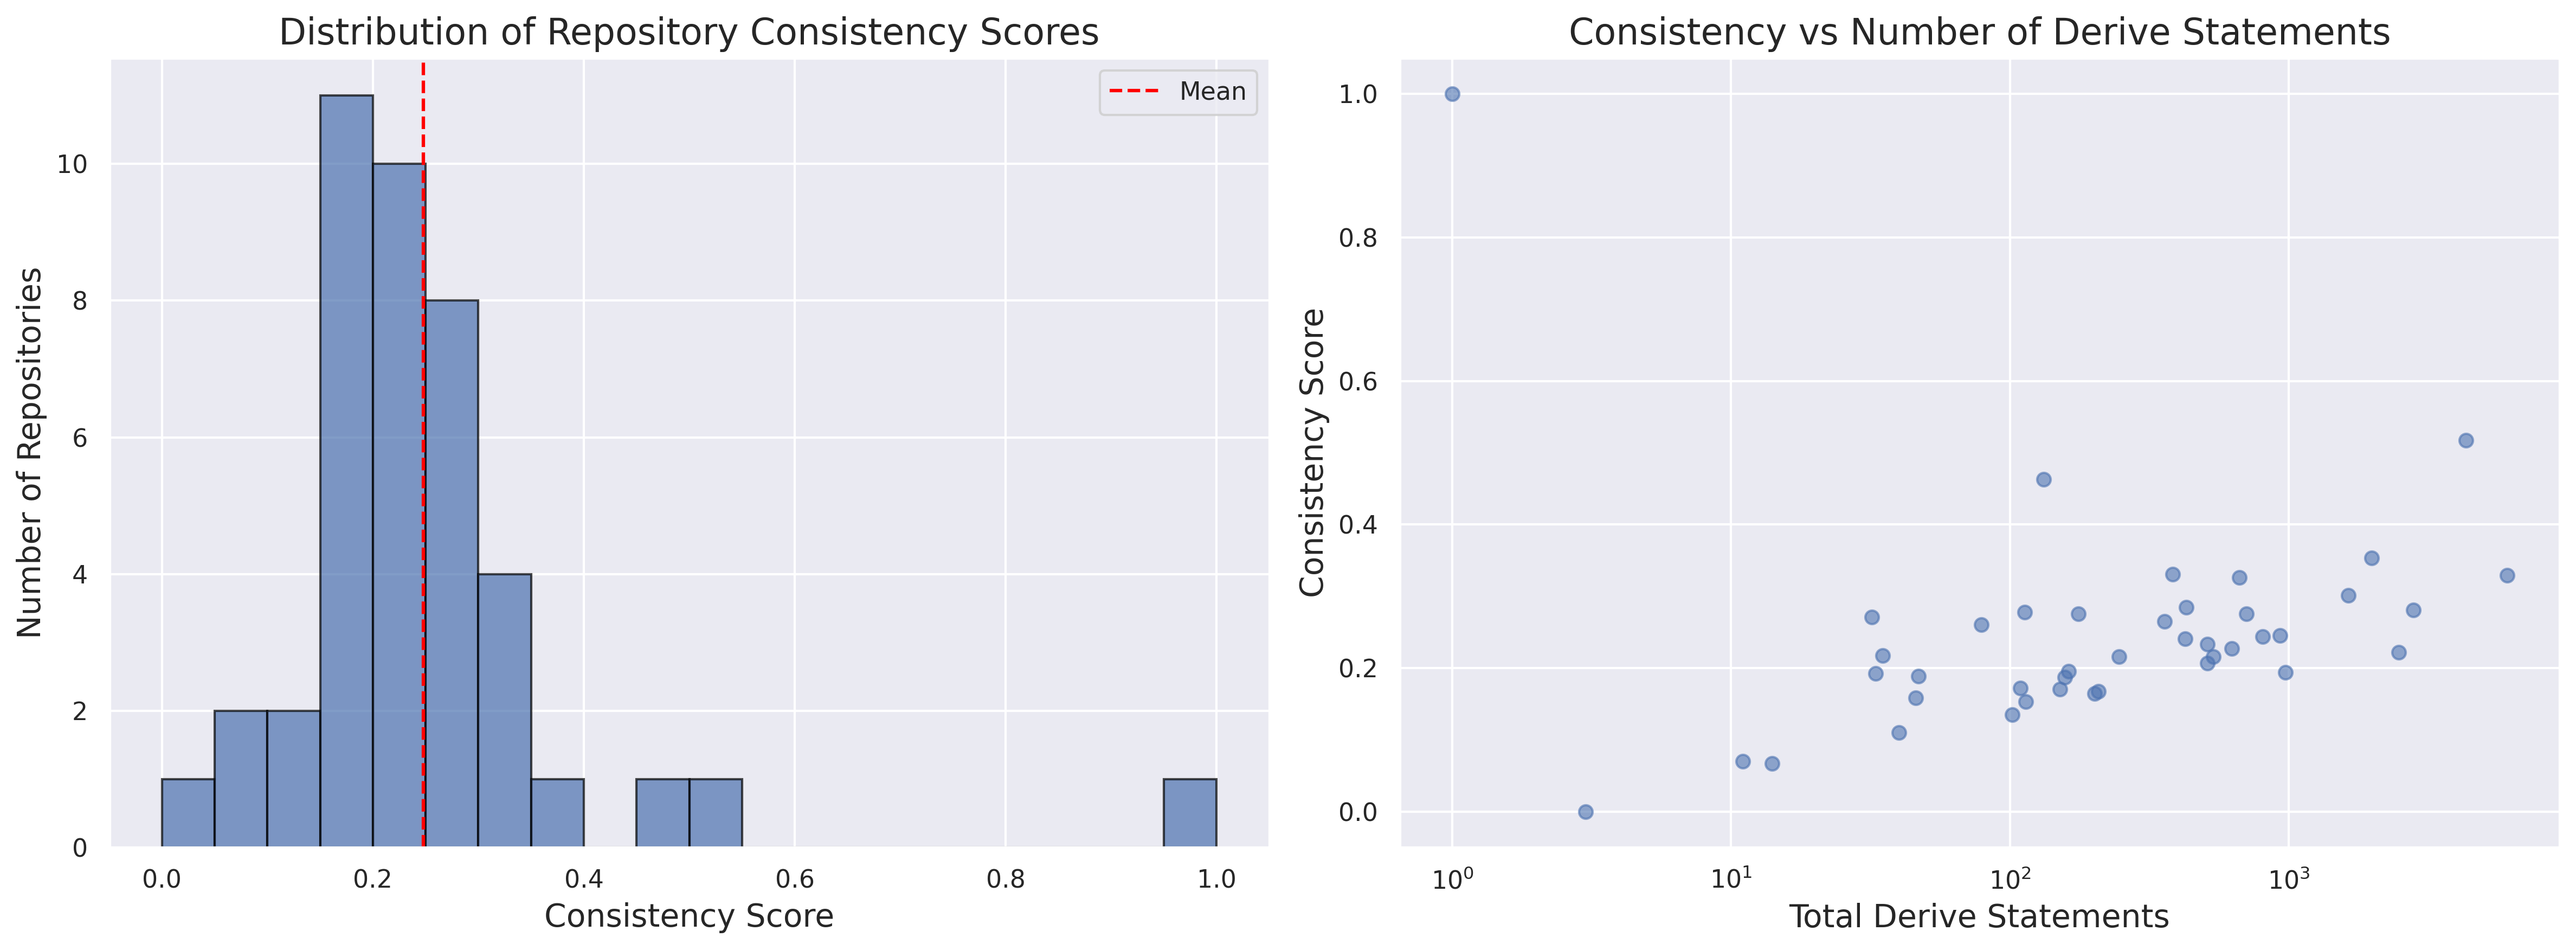

In [5]:
repo_consistency = {}
repo_stats = {}

for repo in multi_derive_df['repository'].unique():
    repo_data = multi_derive_df[multi_derive_df['repository'] == repo]
    derive_patterns = repo_data['derive_list'].tolist()
    
    consistency_score = calculate_consistency_score(derive_patterns)
    
    repo_consistency[repo] = consistency_score
    repo_stats[repo] = {
        'consistency_score': consistency_score,
        'total_derives': len(repo_data),
        'unique_patterns': len(set(tuple(pattern) for pattern in derive_patterns)),
        'avg_derives_per_statement': np.mean([len(pattern) for pattern in derive_patterns])
    }

# Convert to DataFrame for analysis
consistency_df = pd.DataFrame.from_dict(repo_stats, orient='index').reset_index()
consistency_df.columns = ['repository'] + list(consistency_df.columns[1:])
consistency_df = consistency_df.sort_values('consistency_score', ascending=False)

print("Repository consistency scores (top 15):")
display(consistency_df.head(15))

print(f"\nConsistency score statistics:")
print(f"  Mean: {consistency_df['consistency_score'].mean():.3f}")
print(f"  Median: {consistency_df['consistency_score'].median():.3f}")
print(f"  Std Dev: {consistency_df['consistency_score'].std():.3f}")
print(f"  Min: {consistency_df['consistency_score'].min():.3f}")
print(f"  Max: {consistency_df['consistency_score'].max():.3f}")

# Visualize consistency scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=300)

# Histogram of consistency scores
ax1.hist(consistency_df['consistency_score'], bins=20, alpha=0.7, edgecolor='black')
ax1.set_xlabel('Consistency Score', fontsize=14)
ax1.set_ylabel('Number of Repositories', fontsize=14)
ax1.set_title('Distribution of Repository Consistency Scores', fontsize=16)
ax1.axvline(consistency_df['consistency_score'].mean(), color='red', linestyle='--', label='Mean')
ax1.legend()

# Scatter plot: consistency vs total derives
ax2.scatter(consistency_df['total_derives'], consistency_df['consistency_score'], alpha=0.6)
ax2.set_xlabel('Total Derive Statements', fontsize=14)
ax2.set_ylabel('Consistency Score', fontsize=14)
ax2.set_title('Consistency vs Number of Derive Statements', fontsize=16)
ax2.set_xscale('log')

plt.tight_layout()
plt.savefig(outdir / "repository_consistency.png", dpi=300, bbox_inches="tight")
plt.show()

Derive ordering patterns by repository category:


consistency_score                     total_derives          \
                              mean median    std count          mean  median   
category                                                                       
cli_tools                    0.240  0.260  0.114     9       513.333   162.0   
core_rust                    0.329  0.329    NaN     1      6066.000  6066.0   
data                         0.206  0.206    NaN     1       510.000   510.0   
dev_tools                    0.327  0.327  0.037     2      1807.000  1807.0   
educational                  0.227  0.217  0.040     3        33.333    33.0   
gamedev_graphics             0.222  0.222    NaN     1      2476.000  2476.0   
other                        0.251  0.216  0.187    24       494.667   227.0   
security                     0.135  0.135    NaN     1       102.000   102.0   

                 unique_patterns          
                            mean  median  
category                                  
cli_tools                124.222    23.0  
core_rust               1000.000  1000.0  
data                     148.000   148.0  
dev_tools                263.500   263.5  
educational               10.000     8.0  
gamedev_graphics         770.000   770.0  
other                     93.083    80.5  
security                  32.000    32.0


Repositories per category:
  other: 24
  cli_tools: 9
  educational: 3
  dev_tools: 2
  data: 1
  core_rust: 1
  gamedev_graphics: 1
  security: 1

ANOVA test for consistency differences across categories:
  F-statistic: 0.035
  p-value: 0.965404
  Significant difference: No


/tmp/ipykernel_248858/2779092479.py:90: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot(category_data, labels=category_names)


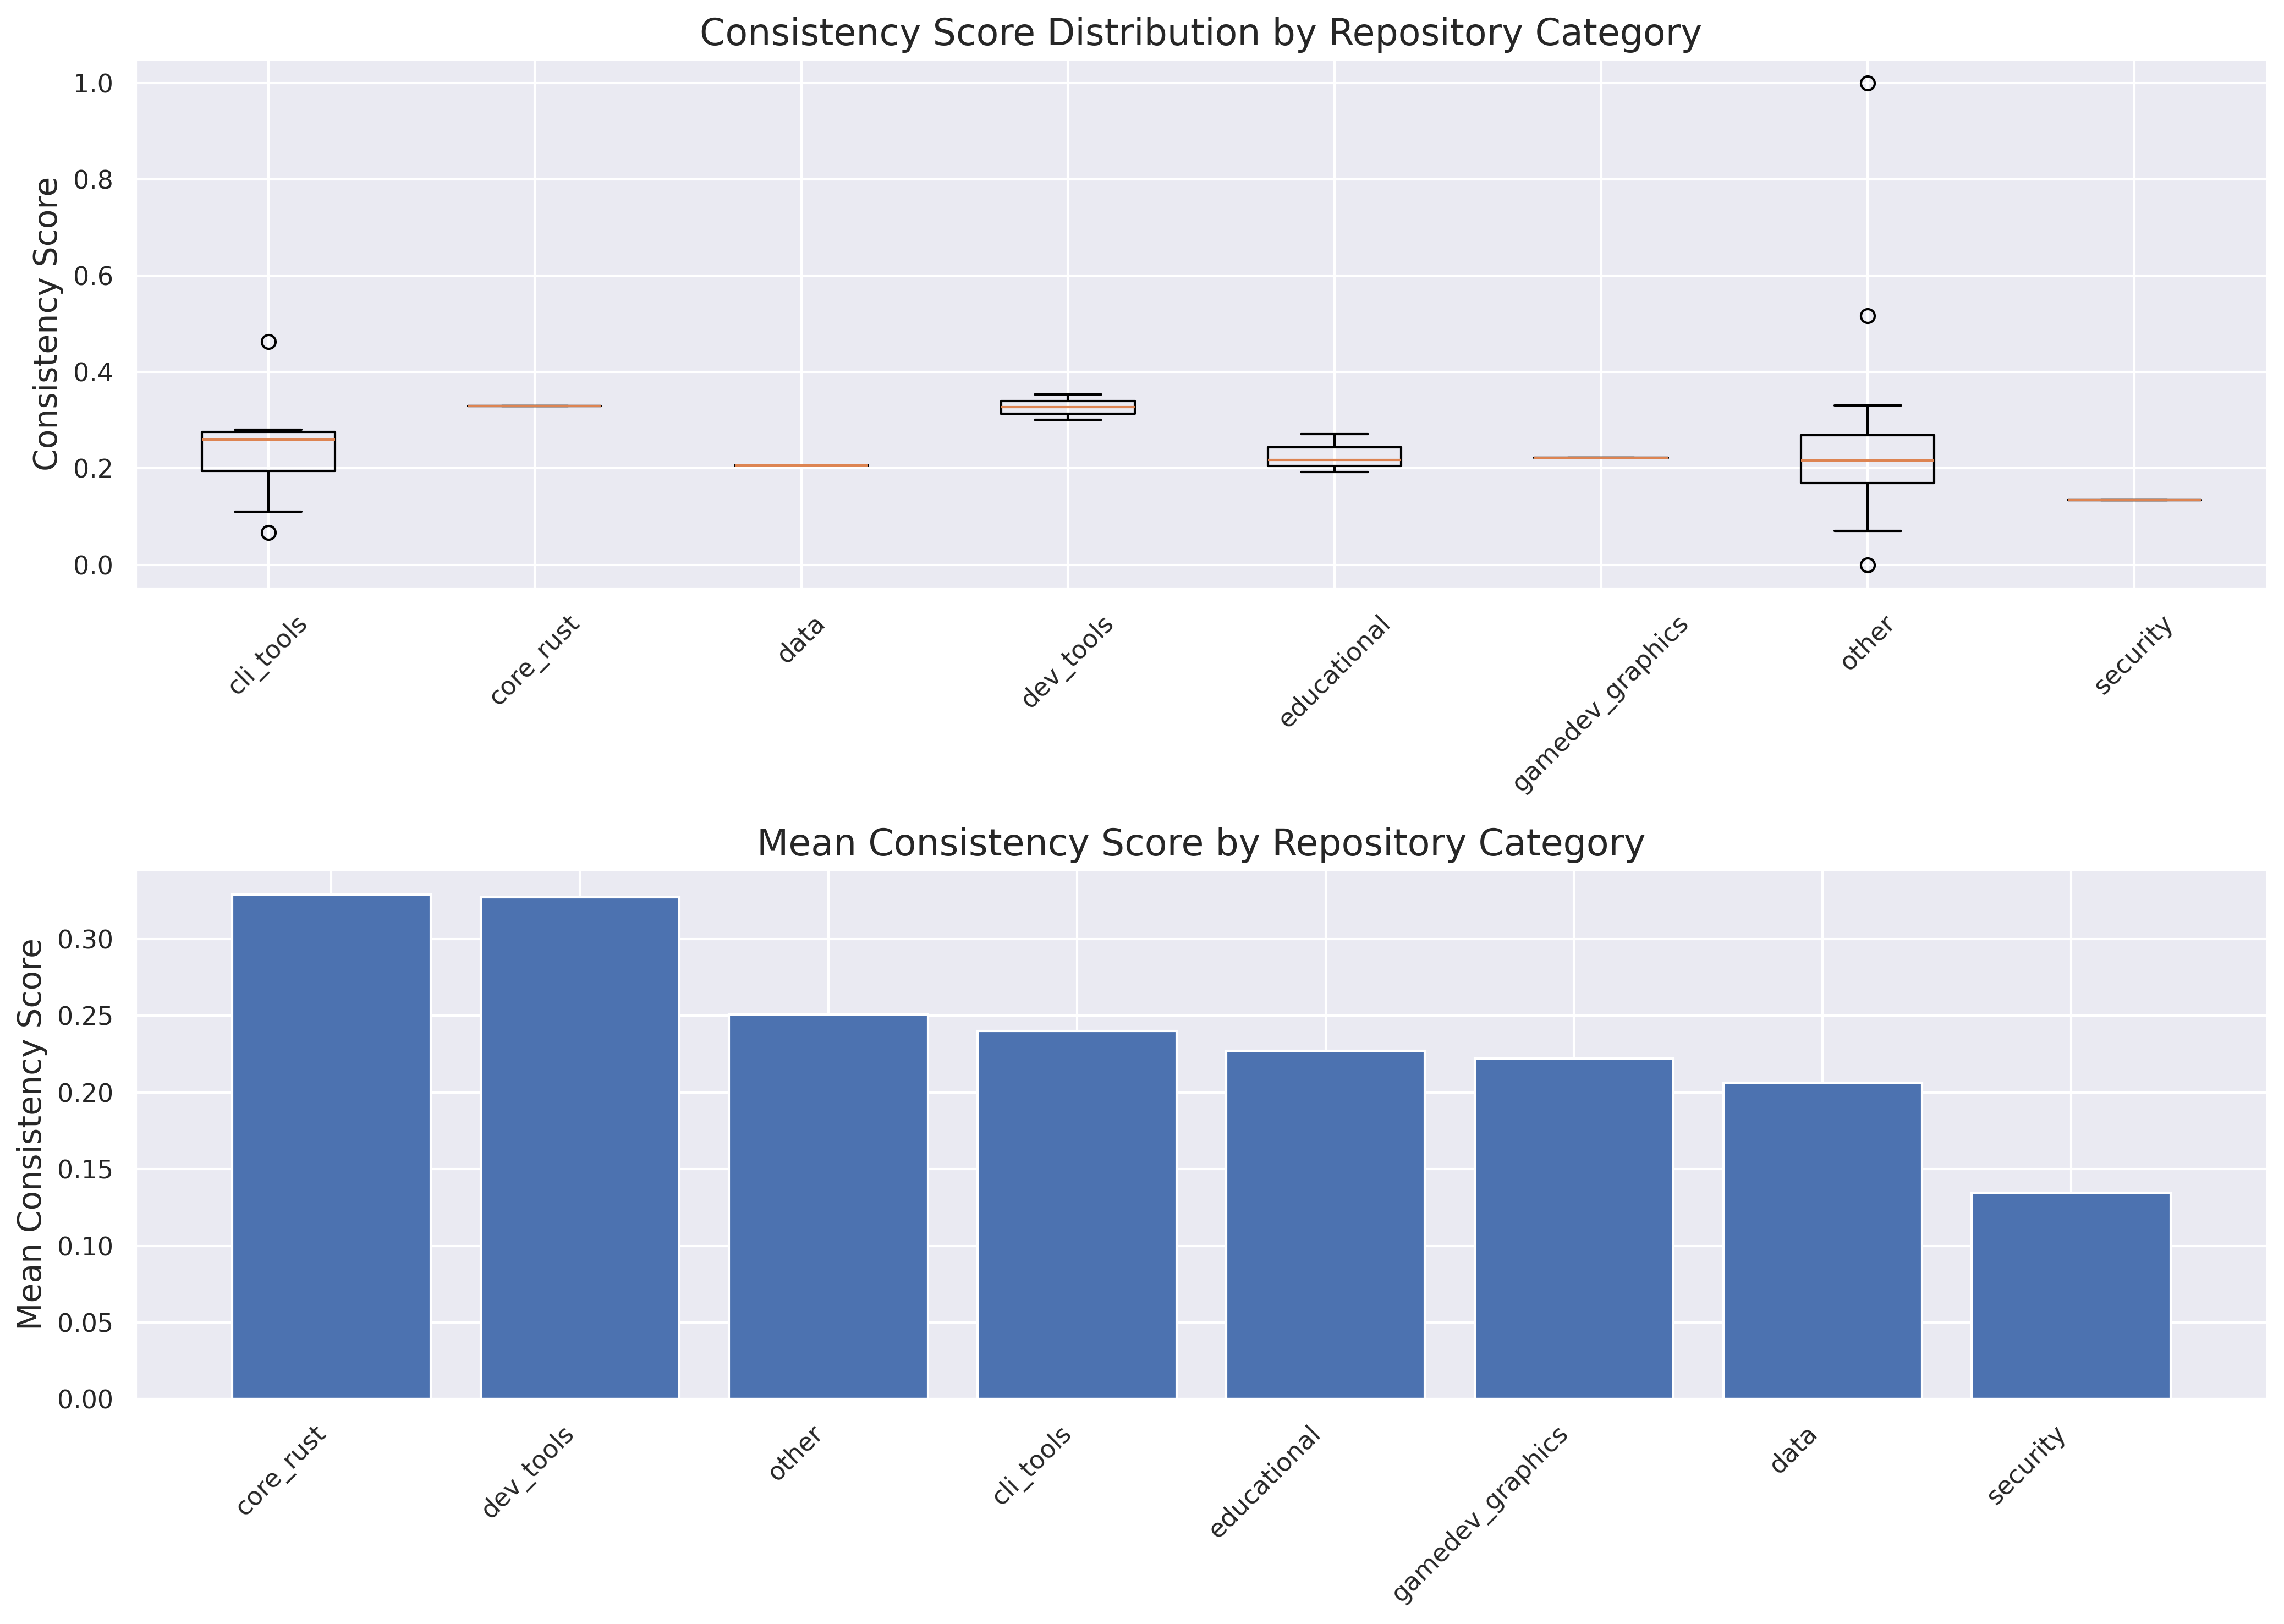

In [7]:
## Q3: Variation Across Communities and Libraries

# Categorize repositories by domain/type
def categorize_repository(repo_name):
    """Categorize repository by domain based on name and known projects."""
    repo_name_lower = repo_name.lower()
    
    # Core Rust ecosystem
    if repo_name in ['rust', 'rustc', 'std']:
        return 'core_rust'
    
    # Web frameworks and servers
    if repo_name in ['actix-web', 'warp', 'axum', 'rocket', 'hyper', 'reqwest', 'tower']:
        return 'web'
    
    # Game engines and graphics
    if repo_name in ['bevy', 'winit', 'wgpu', 'vulkano']:
        return 'gamedev_graphics'
    
    # CLI tools and system utilities
    if repo_name in ['ripgrep', 'fd', 'exa', 'bat', 'starship', 'zellij', 'alacritty', 'helix', 'zed']:
        return 'cli_tools'
    
    # Development tools and language tooling
    if repo_name in ['cargo', 'rustfmt', 'clippy', 'rust-analyzer', 'swc', 'ruff', 'miri']:
        return 'dev_tools'
    
    # Blockchain and crypto
    if 'solana' in repo_name_lower or 'substrate' in repo_name_lower or repo_name in ['polkadot']:
        return 'blockchain'
    
    # Data processing and databases
    if repo_name in ['polars', 'datafusion', 'arrow', 'surrealdb']:
        return 'data'
    
    # Security and authentication  
    if repo_name in ['vaultwarden', 'bitwarden']:
        return 'security'
    
    # Learning and educational
    if repo_name in ['rustlings', 'rust-course', 'mdBook']:
        return 'educational'
    
    # Operating systems and embedded
    if 'os' in repo_name_lower or repo_name in ['redox', 'tock']:
        return 'systems'
    
    # Package manager
    if repo_name in ['cargo']:
        return 'package_mgmt'
    
    # Default category
    return 'other'

# Apply categorization
consistency_df['category'] = consistency_df['repository'].apply(categorize_repository)

# Analyze patterns by category
category_analysis = consistency_df.groupby('category').agg({
    'consistency_score': ['mean', 'median', 'std', 'count'],
    'total_derives': ['mean', 'median'],
    'unique_patterns': ['mean', 'median']
}).round(3)

print("Derive ordering patterns by repository category:")
display(category_analysis)

# Statistical test for differences between categories
categories_with_data = consistency_df.groupby('category').size()
print(f"\nRepositories per category:")
for cat, count in categories_with_data.sort_values(ascending=False).items():
    print(f"  {cat}: {count}")

# ANOVA test for consistency score differences
category_groups = [group['consistency_score'].values for name, group in consistency_df.groupby('category') if len(group) >= 3]
if len(category_groups) >= 2:
    f_stat, p_value = stats.f_oneway(*category_groups)
    print(f"\nANOVA test for consistency differences across categories:")
    print(f"  F-statistic: {f_stat:.3f}")
    print(f"  p-value: {p_value:.6f}")
    print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")

# Visualize category differences
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), dpi=300)

# Box plot of consistency scores by category
category_data = [group['consistency_score'].values for name, group in consistency_df.groupby('category')]
category_names = [name for name, group in consistency_df.groupby('category')]

ax1.boxplot(category_data, labels=category_names)
ax1.set_ylabel('Consistency Score', fontsize=14)
ax1.set_title('Consistency Score Distribution by Repository Category', fontsize=16)
ax1.tick_params(axis='x', rotation=45)

# Bar plot of mean consistency by category
category_means = consistency_df.groupby('category')['consistency_score'].mean().sort_values(ascending=False)
ax2.bar(range(len(category_means)), category_means.values)
ax2.set_xticks(range(len(category_means)))
ax2.set_xticklabels(category_means.index, rotation=45, ha='right')
ax2.set_ylabel('Mean Consistency Score', fontsize=14)
ax2.set_title('Mean Consistency Score by Repository Category', fontsize=16)

plt.tight_layout()
plt.savefig(outdir / "category_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
## Q4: Patterns versus Noise

# Test statistical significance of observed ordering preferences
def test_ordering_significance(forward_count, reverse_count, alpha=0.05):
    """Test if ordering preference is statistically significant using binomial test."""
    total = forward_count + reverse_count
    if total == 0:
        return None, None, None
    
    # Null hypothesis: equal preference (p = 0.5)
    p_value = stats.binomtest(forward_count, total, 0.5, alternative='two-sided').pvalue
    # Effect size (how strong is the preference)
    preference_strength = abs(forward_count - reverse_count) / total
    
    # Confidence interval for the preference ratio
    ci_low, ci_high = stats.beta.interval(1-alpha, forward_count + 1, reverse_count + 1)
    
    return p_value, preference_strength, (ci_low, ci_high)

# Apply significance testing to derive pair preferences
significant_patterns = []
for _, row in pair_comparison_df.iterrows():
    p_val, strength, ci = test_ordering_significance(
        row['forward_count'], 
        row['reverse_count']
    )
    
    if p_val is not None:
        significant_patterns.append({
            'pair': row['pair'],
            'total_occurrences': row['total'],
            'preferred_order': row['preferred_order'], 
            'preference_ratio': row['forward_preference'],
            'p_value': p_val,
            'effect_size': strength,
            'is_significant': p_val < 0.05,
            'confidence_interval': ci
        })

significance_df = pd.DataFrame(significant_patterns).sort_values('p_value')

print("Statistical significance of derive ordering patterns:")
print(f"Total patterns tested: {len(significance_df)}")
print(f"Statistically significant patterns (p < 0.05): {sum(significance_df['is_significant'])}")
print(f"Highly significant patterns (p < 0.001): {sum(significance_df['p_value'] < 0.001)}")

print("\nMost significant ordering preferences:")
display(significance_df.head(15)[['pair', 'preferred_order', 'total_occurrences', 'preference_ratio', 'p_value', 'effect_size']])

# Bootstrap analysis for pattern stability
def bootstrap_pattern_analysis(sequences, n_bootstrap=1000):
    """Bootstrap analysis to test stability of observed patterns."""
    sequence_counts = Counter(sequences)
    top_patterns = [seq for seq, count in sequence_counts.most_common(10)]
    
    bootstrap_results = {pattern: [] for pattern in top_patterns}
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        bootstrap_sample = np.random.choice(sequences, size=len(sequences), replace=True)
        bootstrap_counts = Counter(bootstrap_sample)
        
        total_bootstrap = len(bootstrap_sample)
        for pattern in top_patterns:
            proportion = bootstrap_counts[pattern] / total_bootstrap
            bootstrap_results[pattern].append(proportion)
    
    return bootstrap_results

# Perform bootstrap analysis
print(f"\nBootstrap analysis for pattern stability...")
bootstrap_results = bootstrap_pattern_analysis(all_sequences, n_bootstrap=1000)

bootstrap_stats = {}
for pattern, proportions in bootstrap_results.items():
    bootstrap_stats[pattern] = {
        'mean_proportion': np.mean(proportions),
        'std_proportion': np.std(proportions),
        'ci_low': np.percentile(proportions, 2.5),
        'ci_high': np.percentile(proportions, 97.5),
        'original_count': sequence_frequency[pattern]
    }

bootstrap_df = pd.DataFrame.from_dict(bootstrap_stats, orient='index')
bootstrap_df = bootstrap_df.sort_values('mean_proportion', ascending=False)

print("Bootstrap confidence intervals for top derive sequences:")
display(bootstrap_df)

# Entropy analysis
def calculate_ordering_entropy(sequences):
    """Calculate entropy of derive ordering patterns."""
    if not sequences:
        return 0
    
    counts = Counter(sequences)
    total = sum(counts.values())
    probabilities = [count / total for count in counts.values()]
    
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    
    # Normalize by theoretical maximum entropy
    max_entropy = np.log2(len(counts)) if len(counts) > 1 else 0
    normalized_entropy = entropy / max_entropy if max_entropy > 0 else 0
    
    return entropy, normalized_entropy

overall_entropy, normalized_entropy = calculate_ordering_entropy(all_sequences)
print(f"\nOverall ordering entropy analysis:")
print(f"  Raw entropy: {overall_entropy:.3f} bits")
print(f"  Normalized entropy: {normalized_entropy:.3f} (0=perfectly ordered, 1=completely random)")
print(f"  Interpretation: {'High structure/patterns' if normalized_entropy < 0.7 else 'Mostly random' if normalized_entropy > 0.9 else 'Moderate structure'}")

Statistical significance of derive ordering patterns:
Total patterns tested: 28
Statistically significant patterns (p < 0.05): 23
Highly significant patterns (p < 0.001): 21

Most significant ordering preferences:


,pair,preferred_order,total_occurrences,preference_ratio,p_value,effect_size
1,"PartialEq, Eq",PartialEq → Eq,9670,0.746432,0.000000e+00,0.492865
3,"Clone, PartialEq",Clone → PartialEq,7374,0.896800,0.000000e+00,0.793599
5,"Debug, PartialEq",Debug → PartialEq,3749,0.860496,0.000000e+00,0.720992
8,"Copy, PartialEq",Copy → PartialEq,1812,0.950331,0.000000e+00,0.900662
12,"Debug, Serialize",Debug → Serialize,1160,0.894828,1.460449e-181,0.789655
4,"Serialize, Deserialize",Serialize → Deserialize,4595,0.707073,1.755078e-178,0.414146
6,"Debug, Default",Debug → Default,2399,0.752814,1.649811e-141,0.505627
0,"Debug, Clone",Debug → Clone,12317,0.611107,2.692366e-135,0.222213
15,"Clone, Serialize",Clone → Serialize,841,0.892985,1.270684e-130,0.785969
9,"Debug, Eq",Debug → Eq,1662,0.752106,5.384543e-98,0.504212



Bootstrap analysis for pattern stability...


ValueError: a must be 1-dimensional

In [ ]:
## Q5: Implications for Formatting Tools

# Generate rustfmt recommendations based on statistical analysis
def generate_rustfmt_recommendations():
    """Generate concrete recommendations for rustfmt derive ordering."""
    
    recommendations = {
        'high_confidence': [],  # p < 0.001, effect size > 0.6
        'medium_confidence': [], # p < 0.05, effect size > 0.4  
        'low_confidence': [],   # p < 0.05, effect size > 0.2
        'no_preference': []     # Not statistically significant
    }
    
    for _, row in significance_df.iterrows():
        pair_info = {
            'pair': row['pair'],
            'preferred_order': row['preferred_order'],
            'confidence': f"{row['preference_ratio']:.1%} ({row['total_occurrences']} occurrences)",
            'p_value': row['p_value'],
            'effect_size': row['effect_size']
        }
        
        if row['p_value'] < 0.001 and row['effect_size'] > 0.6:
            recommendations['high_confidence'].append(pair_info)
        elif row['p_value'] < 0.05 and row['effect_size'] > 0.4:
            recommendations['medium_confidence'].append(pair_info)
        elif row['p_value'] < 0.05 and row['effect_size'] > 0.2:
            recommendations['low_confidence'].append(pair_info)
        else:
            recommendations['no_preference'].append(pair_info)
    
    return recommendations

recommendations = generate_rustfmt_recommendations()

print("RUSTFMT DERIVE ORDERING RECOMMENDATIONS")
print("=" * 50)

print(f"\n🟢 HIGH CONFIDENCE RECOMMENDATIONS (p < 0.001, strong effect):")
for rec in recommendations['high_confidence']:
    print(f"  {rec['preferred_order']} - {rec['confidence']}")

print(f"\n🟡 MEDIUM CONFIDENCE RECOMMENDATIONS (p < 0.05, moderate effect):")
for rec in recommendations['medium_confidence']:
    print(f"  {rec['preferred_order']} - {rec['confidence']}")

print(f"\n🟠 LOW CONFIDENCE RECOMMENDATIONS (p < 0.05, weak effect):")
for rec in recommendations['low_confidence'][:10]:  # Limit output
    print(f"  {rec['preferred_order']} - {rec['confidence']}")

print(f"\n⚪ NO CLEAR PREFERENCE (not statistically significant):")
for rec in recommendations['no_preference'][:5]:  # Limit output
    print(f"  {rec['pair']} - no strong preference detected")

# Create a comprehensive derive ordering hierarchy
print(f"\n\nPROPOSED RUSTFMT DERIVE ORDERING HIERARCHY:")
print("=" * 50)

# Extract derive ordering rules from high-confidence recommendations
derive_order_rules = []
for rec in recommendations['high_confidence']:
    order_parts = rec['preferred_order'].split(' → ')
    if len(order_parts) == 2:
        derive_order_rules.append((order_parts[0].strip(), order_parts[1].strip()))

# Build directed graph of ordering preferences
from collections import defaultdict
ordering_graph = defaultdict(set)
for first, second in derive_order_rules:
    ordering_graph[first].add(second)

# Attempt topological sort for complete ordering
def topological_sort(graph):
    """Attempt to create a total ordering from partial ordering rules."""
    in_degree = defaultdict(int)
    all_nodes = set()
    
    for node, neighbors in graph.items():
        all_nodes.add(node)
        for neighbor in neighbors:
            all_nodes.add(neighbor)
            in_degree[neighbor] += 1
    
    # Kahn's algorithm
    queue = [node for node in all_nodes if in_degree[node] == 0]
    result = []
    
    while queue:
        # Sort queue for deterministic output
        queue.sort()
        node = queue.pop(0)
        result.append(node)
        
        for neighbor in graph[node]:
            in_degree[neighbor] -= 1
            if in_degree[neighbor] == 0:
                queue.append(neighbor)
    
    return result

proposed_order = topological_sort(ordering_graph)

print("Based on statistically significant patterns, proposed ordering:")
for i, derive_trait in enumerate(proposed_order):
    print(f"  {i+1}. {derive_trait}")

if len(proposed_order) < len(derive_frequency):
    remaining_traits = [trait for trait, _ in derive_frequency.most_common(20) 
                       if trait not in proposed_order]
    print(f"\nAdditional common traits (no strong ordering evidence):")
    for trait in remaining_traits[:10]:
        print(f"  - {trait}")

# Summary statistics for the analysis
print(f"\n\nANALYSIS SUMMARY:")
print("=" * 30)
print(f"Total derive statements analyzed: {len(df_processed):,}")
print(f"Multi-derive statements: {len(multi_derive_df):,}")
print(f"Unique repositories: {df_processed['repository'].nunique()}")
print(f"Unique derive traits found: {len(derive_frequency)}")
print(f"Derive pair patterns analyzed: {len(pair_comparison_df)}")
print(f"Statistically significant patterns: {sum(significance_df['is_significant'])}")
print(f"High-confidence recommendations: {len(recommendations['high_confidence'])}")
print(f"Overall ordering entropy: {normalized_entropy:.3f} (lower = more structured)")

# Calculate coverage of recommendations
total_occurrences = sum(significance_df['total_occurrences'])
high_conf_coverage = sum(rec['total_occurrences'] for rec in recommendations['high_confidence'])
med_conf_coverage = sum(rec['total_occurrences'] for rec in recommendations['medium_confidence'])

print(f"Coverage of high-confidence rules: {high_conf_coverage/total_occurrences:.1%} of all pair occurrences")
print(f"Coverage of med+high rules: {(high_conf_coverage + med_conf_coverage)/total_occurrences:.1%} of all pair occurrences")

In [ ]:
## Comprehensive Visualizations

# Create a comprehensive visualization suite
fig = plt.figure(figsize=(20, 24), dpi=300)

# 1. Most common derive traits (top 15)
ax1 = plt.subplot(4, 2, 1)
top_derives = derive_frequency.most_common(15)
derives, counts = zip(*top_derives)
bars = ax1.barh(range(len(derives)), counts)
ax1.set_yticks(range(len(derives)))
ax1.set_yticklabels(derives)
ax1.set_xlabel('Frequency', fontsize=12)
ax1.set_title('Most Common Derive Traits', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
# Add count labels on bars
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width + max(counts) * 0.01, bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', ha='left', va='center', fontsize=10)

# 2. Derive pair ordering preferences heatmap
ax2 = plt.subplot(4, 2, 2)
# Create matrix for top derive pairs
top_traits = [trait for trait, _ in derive_frequency.most_common(8)]
preference_matrix = np.zeros((len(top_traits), len(top_traits)))

for i, trait1 in enumerate(top_traits):
    for j, trait2 in enumerate(top_traits):
        if i != j:
            forward = sequence_frequency.get((trait1, trait2), 0)
            reverse = sequence_frequency.get((trait2, trait1), 0)
            total = forward + reverse
            if total > 0:
                preference_matrix[i, j] = forward / total

im = ax2.imshow(preference_matrix, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)
ax2.set_xticks(range(len(top_traits)))
ax2.set_yticks(range(len(top_traits)))
ax2.set_xticklabels(top_traits, rotation=45, ha='right')
ax2.set_yticklabels(top_traits)
ax2.set_title('Derive Ordering Preferences Heatmap\n(rows before columns)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax2, shrink=0.8, label='Preference Ratio')

# 3. Repository consistency score distribution
ax3 = plt.subplot(4, 2, 3)
ax3.hist(consistency_df['consistency_score'], bins=25, alpha=0.7, edgecolor='black', color='skyblue')
ax3.axvline(consistency_df['consistency_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {consistency_df["consistency_score"].mean():.3f}')
ax3.axvline(consistency_df['consistency_score'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {consistency_df["consistency_score"].median():.3f}')
ax3.set_xlabel('Consistency Score', fontsize=12)
ax3.set_ylabel('Number of Repositories', fontsize=12)
ax3.set_title('Distribution of Repository Consistency Scores', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Top repositories by derive count
ax4 = plt.subplot(4, 2, 4)
top_repos = consistency_df.nlargest(15, 'total_derives')
bars = ax4.barh(range(len(top_repos)), top_repos['total_derives'])
ax4.set_yticks(range(len(top_repos)))
ax4.set_yticklabels(top_repos['repository'])
ax4.set_xlabel('Total Derive Statements', fontsize=12)
ax4.set_title('Repositories by Derive Statement Count', fontsize=14, fontweight='bold')
ax4.invert_yaxis()
# Add count labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax4.text(width + max(top_repos['total_derives']) * 0.01, bar.get_y() + bar.get_height()/2, 
             f'{int(width):,}', ha='left', va='center', fontsize=10)

# 5. Consistency vs repository size
ax5 = plt.subplot(4, 2, 5)
scatter = ax5.scatter(consistency_df['total_derives'], consistency_df['consistency_score'], 
                     alpha=0.6, s=50, c=consistency_df['unique_patterns'], cmap='viridis')
ax5.set_xlabel('Total Derive Statements (log scale)', fontsize=12)
ax5.set_ylabel('Consistency Score', fontsize=12)
ax5.set_title('Consistency vs Repository Size', fontsize=14, fontweight='bold')
ax5.set_xscale('log')
ax5.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax5, shrink=0.8, label='Unique Patterns')

# 6. Statistical significance of ordering patterns
ax6 = plt.subplot(4, 2, 6)
sig_data = significance_df[significance_df['total_occurrences'] >= 20]  # Filter for visibility
colors = ['red' if p < 0.001 else 'orange' if p < 0.01 else 'yellow' if p < 0.05 else 'gray' 
          for p in sig_data['p_value']]
scatter = ax6.scatter(sig_data['total_occurrences'], sig_data['effect_size'], 
                     c=colors, alpha=0.7, s=60)
ax6.set_xlabel('Total Occurrences (log scale)', fontsize=12)
ax6.set_ylabel('Effect Size', fontsize=12)
ax6.set_title('Statistical Significance of Ordering Patterns', fontsize=14, fontweight='bold')
ax6.set_xscale('log')
ax6.grid(True, alpha=0.3)

# Create custom legend for significance levels
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='p < 0.001'),
    Patch(facecolor='orange', label='p < 0.01'),
    Patch(facecolor='yellow', label='p < 0.05'),
    Patch(facecolor='gray', label='p ≥ 0.05')
]
ax6.legend(handles=legend_elements, loc='upper right')

# 7. Category comparison
ax7 = plt.subplot(4, 2, 7)
category_means = consistency_df.groupby('category')['consistency_score'].mean().sort_values(ascending=True)
bars = ax7.barh(range(len(category_means)), category_means.values)
ax7.set_yticks(range(len(category_means)))
ax7.set_yticklabels(category_means.index)
ax7.set_xlabel('Mean Consistency Score', fontsize=12)
ax7.set_title('Mean Consistency Score by Repository Category', fontsize=14, fontweight='bold')
# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax7.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=10)

# 8. Entropy and randomness analysis
ax8 = plt.subplot(4, 2, 8)
# Calculate entropy for each repository
repo_entropies = []
repo_names = []
for repo in multi_derive_df['repository'].unique():
    repo_data = multi_derive_df[multi_derive_df['repository'] == repo]
    if len(repo_data) >= 5:  # Only include repos with sufficient data
        repo_sequences = []
        for seq_list in repo_data['derive_sequences']:
            repo_sequences.extend(seq_list)
        if repo_sequences:
            _, norm_entropy = calculate_ordering_entropy(repo_sequences)
            repo_entropies.append(norm_entropy)
            repo_names.append(repo)

ax8.hist(repo_entropies, bins=20, alpha=0.7, edgecolor='black', color='lightcoral')
ax8.axvline(np.mean(repo_entropies), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(repo_entropies):.3f}')
ax8.axvline(normalized_entropy, color='green', linestyle='--', linewidth=2, label=f'Overall: {normalized_entropy:.3f}')
ax8.set_xlabel('Normalized Entropy', fontsize=12)
ax8.set_ylabel('Number of Repositories', fontsize=12)
ax8.set_title('Distribution of Repository Ordering Entropy\n(0=structured, 1=random)', fontsize=14, fontweight='bold')
ax8.legend()
ax8.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(outdir / "comprehensive_analysis.png", dpi=300, bbox_inches="tight")
plt.savefig(outdir / "comprehensive_analysis.pdf", dpi=300, bbox_inches="tight")
plt.show()

# Save detailed results to CSV files for further analysis
pair_comparison_df.to_csv(outdir / "derive_pair_preferences.csv", index=False)
significance_df.to_csv(outdir / "statistical_significance.csv", index=False)
consistency_df.to_csv(outdir / "repository_consistency.csv", index=False)

print(f"\n📊 All visualizations saved to {outdir}/")
print(f"📄 Detailed CSV results saved to {outdir}/")